In [58]:
!pip install plotly_express kaleido

In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
import json
from wordcloud import WordCloud 
from collections import Counter 
import re 
!pip install plotly
import plotly.express as px


sns.set_theme(style="whitegrid") 
plt.rcParams['figure.figsize'] = (12, 7) 
plt.rcParams['figure.dpi'] = 100 

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [61]:
# 2. Data Acquisition

video_data_filename = 'USvideos.csv'
category_data_filename = 'US_category_id.json'

try:
    df = pd.read_csv(video_data_filename)

    with open(category_data_filename, 'r') as f:
        categories_data = json.load(f)

    category_id_to_name = {item['id']: item['snippet']['title'] for item in categories_data['items']}

    print(f"Data loaded successfully from {video_data_filename}!")
    print("\nInitial DataFrame Head:")
    print(df.head())
    print("\nInitial DataFrame Info:")
    df.info()
    print("\nDataFrame Columns after Step 2:")
    print(df.columns) 
    print("\nSample Category ID Mapping:")
    print(f"Category ID 1: {category_id_to_name.get('1', 'Not Found')}")
    print(f"Category ID 10: {category_id_to_name.get('10', 'Not Found')}")
    print(f"Size of category_id_to_name dictionary: {len(category_id_to_name)}") # <-- ADD THIS

except FileNotFoundError:
    print(f"Error: Make sure '{video_data_filename}' and '{category_data_filename}' are extracted and in the same directory.")
    df = pd.DataFrame(columns=['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
                               'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
                               'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
                               'description'])
    category_id_to_name = {}


if 'category_id' in df.columns:
    df['category_id'] = df['category_id'].astype(str)
else:
    print("WARNING: 'category_id' column not found in DataFrame after loading CSV.")

Data loaded successfully from USvideos.csv!

Initial DataFrame Head:
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

In [62]:
# 3. Data Preprocessing & Feature Engineering

# Convert 'trending_date' and 'publish_time' to datetime objects
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Extract 'publish_date' 
df['publish_date'] = df['publish_time'].dt.date

# Map category_id to actual category names
if 'category_id' in df.columns and category_id_to_name:
    df['category_name'] = df['category_id'].astype(str).map(category_id_to_name)
    df['category_name'] = df['category_name'].fillna('Unknown')
else:
    print("\nERROR: Could not map category_id to category_name. 'category_id' column missing or category_id_to_name is empty.")
    df['category_name'] = 'Unknown'

df['tags'] = df['tags'].fillna('').astype(str).apply(
    lambda x: [tag.lower().strip() for tag in x.split('|') if tag.strip()])

# Handle missing descriptions
df['description'] = df['description'].fillna('')

numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Adding an 'engagement_score' as a sum of likes, dislikes, and comments.
df['engagement_score'] = df['likes'] + df['dislikes'] + df['comment_count']
df['positive_engagement'] = df['likes'] + df['comment_count']

# Engagement Ratios
df['likes_per_comment'] = np.where(df['comment_count'] > 0, df['likes'] / df['comment_count'], 0)
df['comments_per_like'] = np.where(df['likes'] > 0, df['comment_count'] / df['likes'], 0)

# Title/Description Length
df['title_char_count'] = df['title'].apply(len)
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))
df['description_char_count'] = df['description'].apply(len)
df['description_word_count'] = df['description'].apply(lambda x: len(x.split()))

# Capitalization in Titles
df['title_uppercase_ratio'] = df['title'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Publish Day/Hour
df['publish_day_of_week'] = df['publish_time'].dt.day_name()
df['publish_hour'] = df['publish_time'].dt.hour

# Emoji/Special Character Count in Titles
df['title_special_char_count'] = df['title'].apply(lambda x: len(re.findall(r'[^\w\s\.\,\;\:\'\"\!\?\(\)\[\]\{\}\-\_]', x)))


print("\nDataFrame after Preprocessing and Feature Engineering:")
print(df.head())
print("\nDataFrame Info after Preprocessing:")
df.info()

print("\nMissing values after preprocessing:")
print(df[['trending_date', 'publish_time', 'category_name', 'views', 'likes', 'comment_count']].isnull().sum())


DataFrame after Preprocessing and Feature Engineering:
      video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

  category_id              publish_time  \
0          22 2017-11-13 17:13:01+00:00   
1          24 2017-11-13 07:30:00+00:00   
2          23 2017-11-12 19:05:24+00:00   
3          24 2017-11-13 11:00:04+00:00   
4          24 2017-11-12 18:01:41+00:00   

                 


Top 15 Most Trending Categories:
                 category  trending_count
0           Entertainment            9964
1                   Music            6472
2           Howto & Style            4146
3                  Comedy            3457
4          People & Blogs            3210
5         News & Politics            2487
6    Science & Technology            2401
7        Film & Animation            2345
8                  Sports            2174
9               Education            1656
10         Pets & Animals             920
11                 Gaming             817
12        Travel & Events             402
13       Autos & Vehicles             384
14  Nonprofits & Activism              57


C:\Users\butte\AppData\Local\Temp\ipykernel_14020\3272971689.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




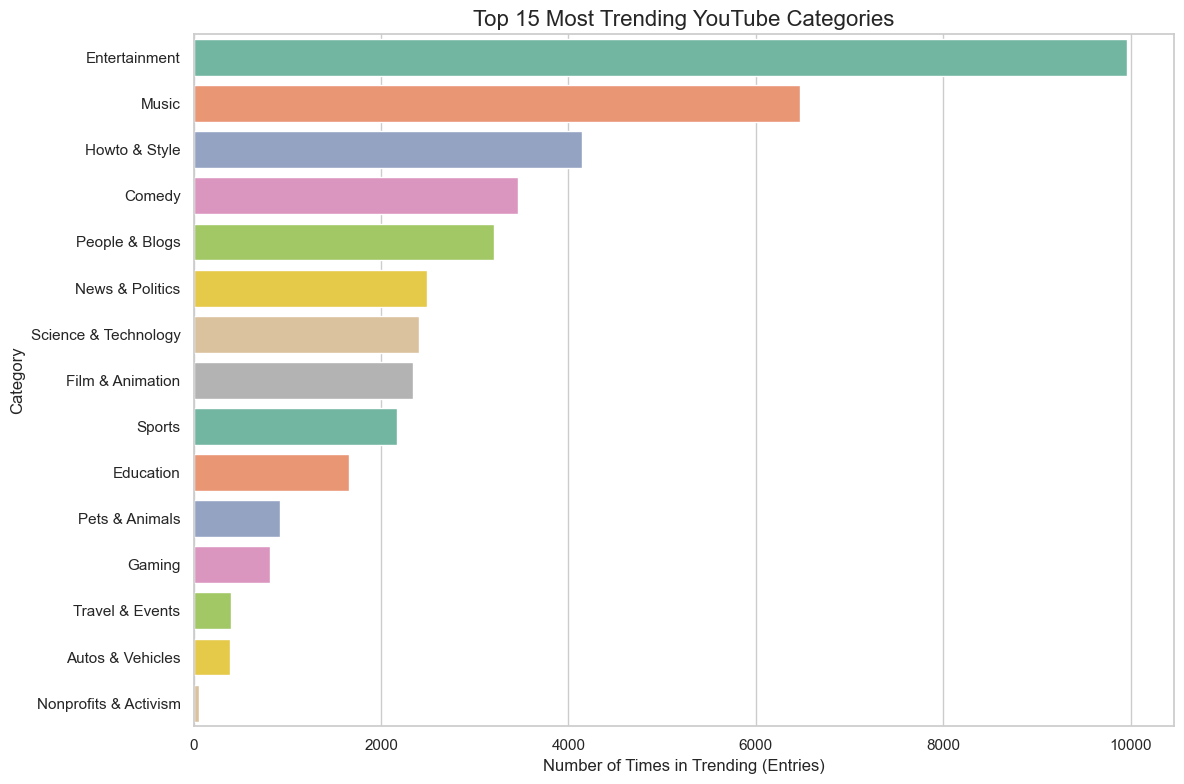

In [63]:
# 4. Fun Analysis & Creative Visualizations

#Category Popularity 
# Counting how many times each category appears in the trending list
category_counts = df['category_name'].value_counts().reset_index()
category_counts.columns = ['category', 'trending_count']

print("\nTop 15 Most Trending Categories:")
print(category_counts.head(15))

# Bar chart of top trending categories (Matplotlib/Seaborn)
plt.figure(figsize=(12, 8))
sns.barplot(x='trending_count', y='category', data=category_counts.head(15), palette='Set2')
plt.title('Top 15 Most Trending YouTube Categories', fontsize=16)
plt.xlabel('Number of Times in Trending (Entries)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

# Interactive Bar Chart with Plotly (Direct Usage)
fig = px.bar(category_counts.head(15), x='trending_count', y='category',
             orientation='h',
             title='Interactive Top 15 Most Trending YouTube Categories',
             labels={'trending_count': 'Number of Times in Trending', 'category': 'Category'},
             color='trending_count',
             color_continuous_scale=px.colors.sequential.RdPu)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()



Average Engagement Ratios for Trending Videos:
Avg Likes per View: 0.0344
Avg Comments per View: 0.0045
Avg Dislikes per View: 0.0016
Avg Like/Dislike Ratio: 0.9292
Avg Likes per Comment (where comments > 0): 19.4694
Avg Comments per Like (where likes > 0): 0.1851


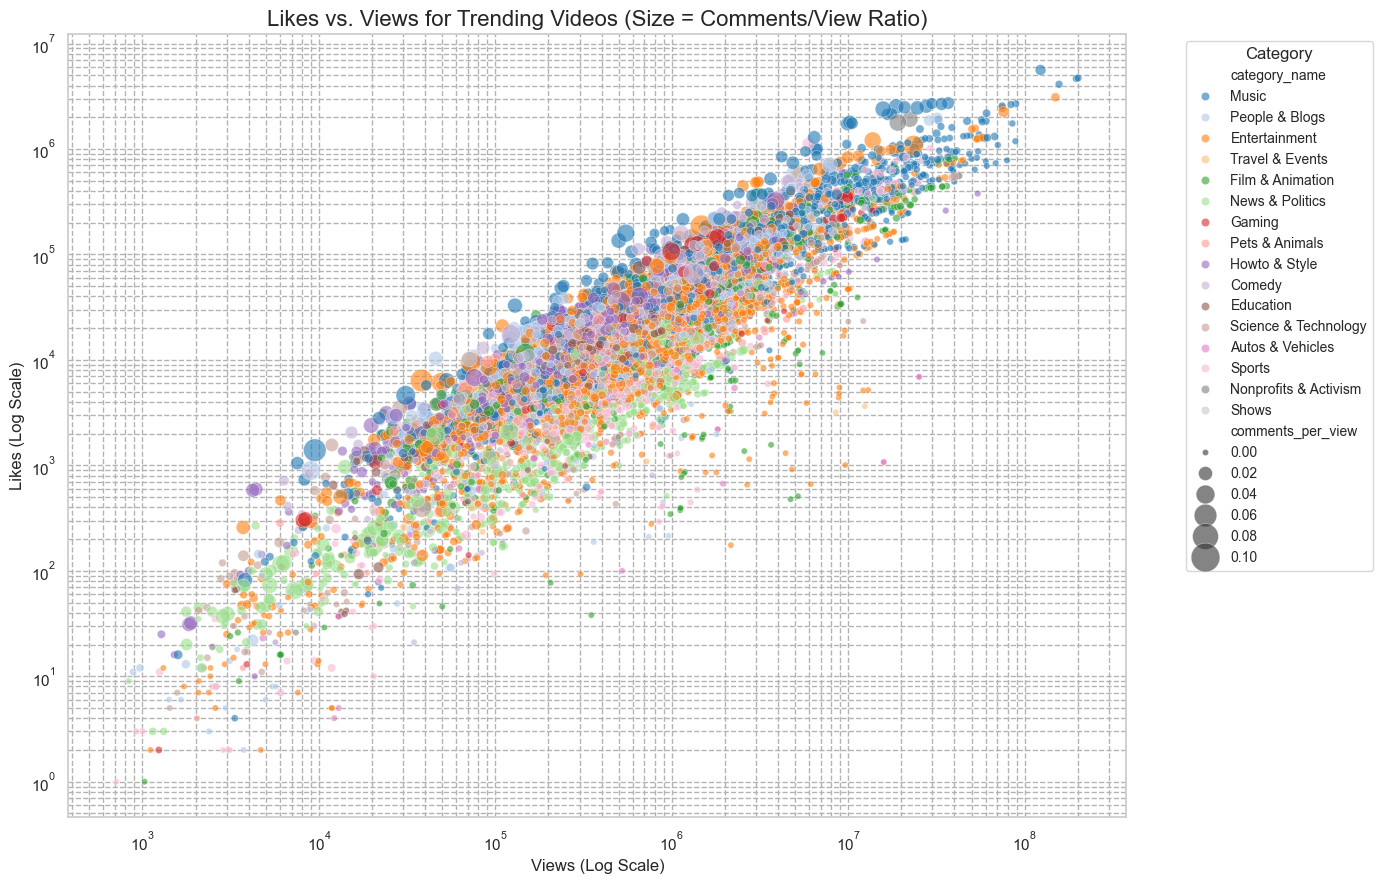

In [64]:
# 4.2 Engagement Ratios 
df['likes_per_view'] = np.where(df['views'] > 0, df['likes'] / df['views'], 0)
df['comments_per_view'] = np.where(df['views'] > 0, df['comment_count'] / df['views'], 0)
df['dislikes_per_view'] = np.where(df['views'] > 0, df['dislikes'] / df['views'], 0)
df['like_dislike_ratio'] = np.where((df['likes'] + df['dislikes']) > 0, df['likes'] / (df['likes'] + df['dislikes']), 0)

print("\nAverage Engagement Ratios for Trending Videos:")
print(f"Avg Likes per View: {df['likes_per_view'].mean():.4f}")
print(f"Avg Comments per View: {df['comments_per_view'].mean():.4f}")
print(f"Avg Dislikes per View: {df['dislikes_per_view'].mean():.4f}")
print(f"Avg Like/Dislike Ratio: {df['like_dislike_ratio'].mean():.4f}")
print(f"Avg Likes per Comment (where comments > 0): {df[df['comments_per_like'] > 0]['likes_per_comment'].mean():.4f}")
print(f"Avg Comments per Like (where likes > 0): {df[df['likes_per_comment'] > 0]['comments_per_like'].mean():.4f}")


sample_df = df.sample(n=min(10000, len(df)), random_state=42)

plt.figure(figsize=(14, 9))
sns.scatterplot(x='views', y='likes', hue='category_name', data=sample_df,
                size='comments_per_view', sizes=(20, 500), alpha=0.6, palette='tab20')
plt.title('Likes vs. Views for Trending Videos (Size = Comments/View Ratio)', fontsize=16)
plt.xlabel('Views (Log Scale)', fontsize=12)
plt.ylabel('Likes (Log Scale)', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", c=".7")
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

fig = px.scatter(sample_df, x='views', y='likes', color='category_name',
                 size='comments_per_view',
                 hover_data=['title', 'channel_title', 'views', 'likes', 'comment_count'],
                 log_x=True, log_y=True,
                 title='Interactive Likes vs. Views for Trending Videos (Size = Comments/View Ratio)')
fig.show()


 ----Trending Duration Summary ---

Video Trending Summary Head (first few unique videos and their trending stats):
      video_id first_trending_date last_trending_date        publish_time  \
0  -0CMnp02rNY          2018-06-06         2018-06-11 2018-06-04 13:00:00   
1  -0NYY8cqdiQ          2018-02-01         2018-02-01 2018-01-29 14:00:39   
2  -1Hm41N0dUs          2018-04-29         2018-05-01 2018-04-27 07:30:02   
3  -1yT-K3c6YI          2017-11-29         2017-12-02 2017-11-28 18:30:43   
4  -2RVw2_QyxQ          2017-11-14         2017-11-16 2017-11-12 02:39:01   

   trending_appearances  max_views  max_likes  max_comments   category_name  \
0                     6     800359       9773           423   Entertainment   
1                     1     563746       4429            94   Entertainment   
2                     3    2058516      41248          1490          Comedy   
3                     4     231341       7734           846  People & Blogs   
4                     3  

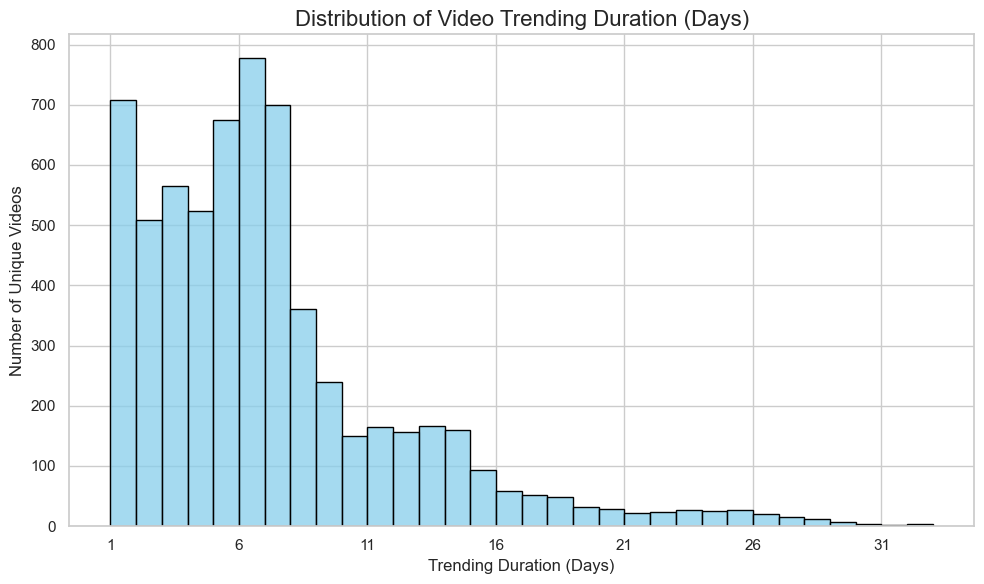

C:\Users\butte\AppData\Local\Temp\ipykernel_14020\979705776.py:83: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




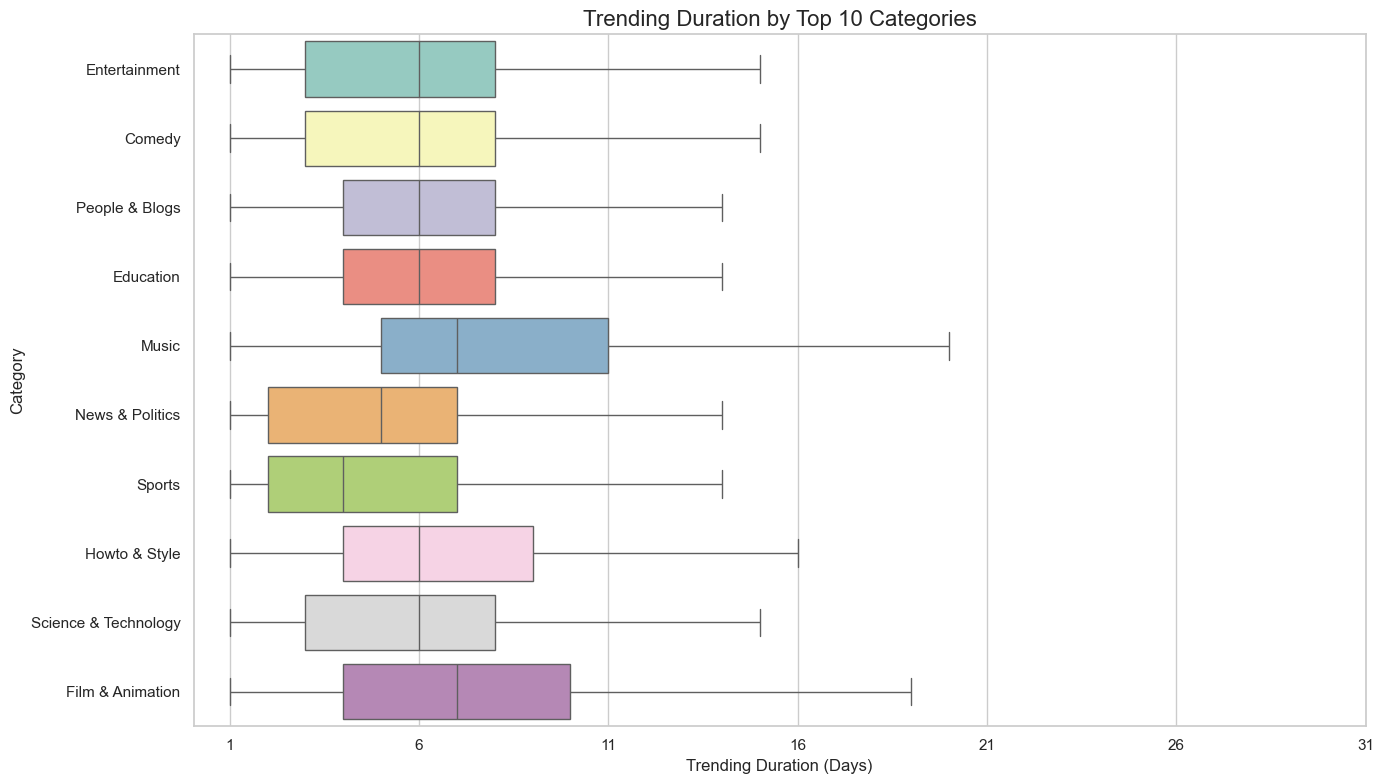

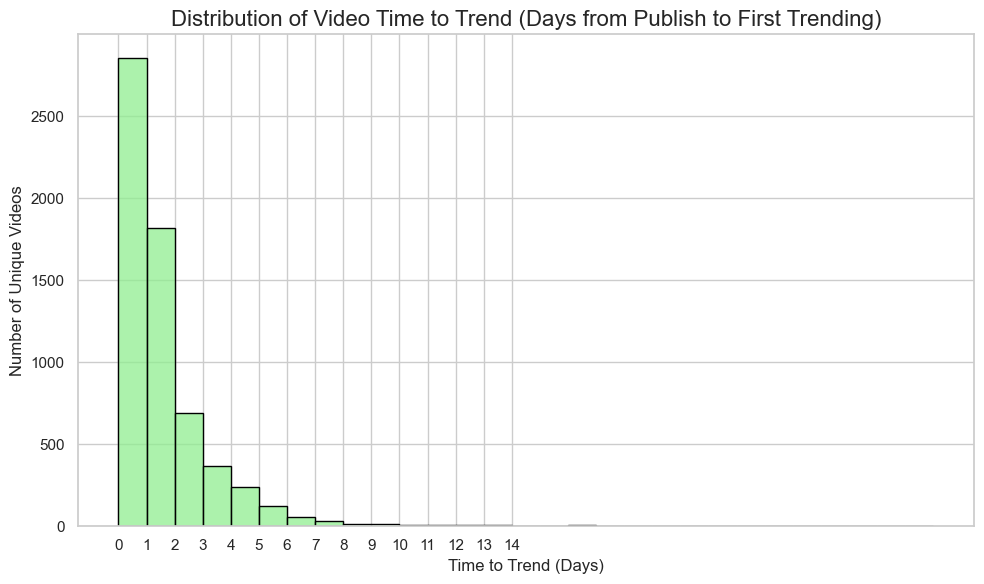

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Trending Duration

print("\n ----Trending Duration Summary ---")

# Group by video_id and aggregate relevant information
video_trending_summary = df.groupby('video_id').agg(
    first_trending_date=('trending_date', 'min'),
    last_trending_date=('trending_date', 'max'),
    # Getting the publish_time from the first entry of that video_id
    publish_time=('publish_time', 'first'),
    trending_appearances=('trending_date', 'count'),
    max_views=('views', 'max'),
    max_likes=('likes', 'max'),
    max_comments=('comment_count', 'max'),
    category_name=('category_name', 'first')
).reset_index()

video_trending_summary['first_trending_date'] = pd.to_datetime(
    video_trending_summary['first_trending_date'], errors='coerce'
)
video_trending_summary['last_trending_date'] = pd.to_datetime(
    video_trending_summary['last_trending_date'], errors='coerce'
)
video_trending_summary['publish_time'] = pd.to_datetime(
    video_trending_summary['publish_time'], errors='coerce'
)

for col in ['first_trending_date', 'last_trending_date', 'publish_time']:
    if video_trending_summary[col].dt.tz is not None:
        video_trending_summary[col] = video_trending_summary[col].dt.tz_localize(None)

video_trending_summary['trending_duration_days'] = (
    video_trending_summary['last_trending_date'] - video_trending_summary['first_trending_date']
).dt.days + 1


# Calculating Time to Trend
# Performing subtraction on the datetime objects directly to get a Timedelta Series
time_diff = video_trending_summary['first_trending_date'] - video_trending_summary['publish_time']
video_trending_summary['time_to_trend_days'] = time_diff.dt.days
video_trending_summary['time_to_trend_days'] = video_trending_summary['time_to_trend_days'].apply(
    lambda x: max(0, x) if pd.notna(x) else np.nan
)
video_trending_summary['time_to_trend_days'] = video_trending_summary['time_to_trend_days'].fillna(0)


# Displaying summary statistics
print("\nVideo Trending Summary Head (first few unique videos and their trending stats):")
print(video_trending_summary.head())
print(f"\nTotal unique videos that trended: {len(video_trending_summary)}")
print(f"Average trending duration: {video_trending_summary['trending_duration_days'].mean():.2f} days")
print(f"Median trending duration: {video_trending_summary['trending_duration_days'].median()} days")
print(f"Average time to trend: {video_trending_summary['time_to_trend_days'].mean():.2f} days")
print(f"Median time to trend: {video_trending_summary['time_to_trend_days'].median()} days")

print("\nData Types of relevant columns after processing:")
print(video_trending_summary[['first_trending_date', 'last_trending_date', 'publish_time', 'trending_duration_days', 'time_to_trend_days']].dtypes)


# Histogram of trending duration (Matplotlib/Seaborn)
plt.figure(figsize=(10, 6))
sns.histplot(video_trending_summary['trending_duration_days'],
             bins=range(1, int(video_trending_summary['trending_duration_days'].max()) + 2),
             kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Video Trending Duration (Days)', fontsize=16)
plt.xlabel('Trending Duration (Days)', fontsize=12)
plt.ylabel('Number of Unique Videos', fontsize=12)
plt.xticks(range(1, int(video_trending_summary['trending_duration_days'].max()) + 1, 1 if video_trending_summary['trending_duration_days'].max() < 15 else 5))
plt.tight_layout()
plt.show()

# Box Plot of Trending Duration by Category (Matplotlib/Seaborn)
top_categories_for_duration = video_trending_summary['category_name'].value_counts().head(10).index
df_filtered_for_duration = video_trending_summary[video_trending_summary['category_name'].isin(top_categories_for_duration)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='trending_duration_days', y='category_name', data=df_filtered_for_duration, palette='Set3', showfliers=False)
plt.title('Trending Duration by Top 10 Categories', fontsize=16)
plt.xlabel('Trending Duration (Days)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(range(1, int(df_filtered_for_duration['trending_duration_days'].max()) + 1, 1 if df_filtered_for_duration['trending_duration_days'].max() < 15 else 5))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
max_days_to_show_time_to_trend = int(video_trending_summary['time_to_trend_days'].max()) + 2
max_days_to_show_plot = min(max_days_to_show_time_to_trend, 30)

sns.histplot(video_trending_summary['time_to_trend_days'],
             bins=range(0, max_days_to_show_plot), 
             kde=False, color='lightgreen', edgecolor='black')
plt.title('Distribution of Video Time to Trend (Days from Publish to First Trending)', fontsize=16)
plt.xlabel('Time to Trend (Days)', fontsize=12)
plt.ylabel('Number of Unique Videos', fontsize=12)
plt.xticks(range(0, min(15, max_days_to_show_plot))) 
plt.tight_layout()
plt.show()


# Interactive Histogram with Plotly 
fig = px.histogram(video_trending_summary, x='time_to_trend_days',
                   
                   nbins=max(5, int(video_trending_summary['time_to_trend_days'].max()) + 1),
                   title='Interactive Distribution of Video Time to Trend (Days)',
                   labels={'time_to_trend_days': 'Time to Trend (Days)', 'count': 'Number of Unique Videos'},
                   color_discrete_sequence=['lightcoral'])

plotly_x_range_max = min(video_trending_summary['time_to_trend_days'].max() + 0.5, 15.5) 
fig.update_xaxes(range=[-0.5, plotly_x_range_max])

fig.show()



--- Title/Tag Analysis (Word Clouds) ---
Length of all_titles string: 2030176
Length of all_tags string: 11336517
Length of all_titles_cleaned string: 1886154
Length of all_tags_cleaned string: 9657214


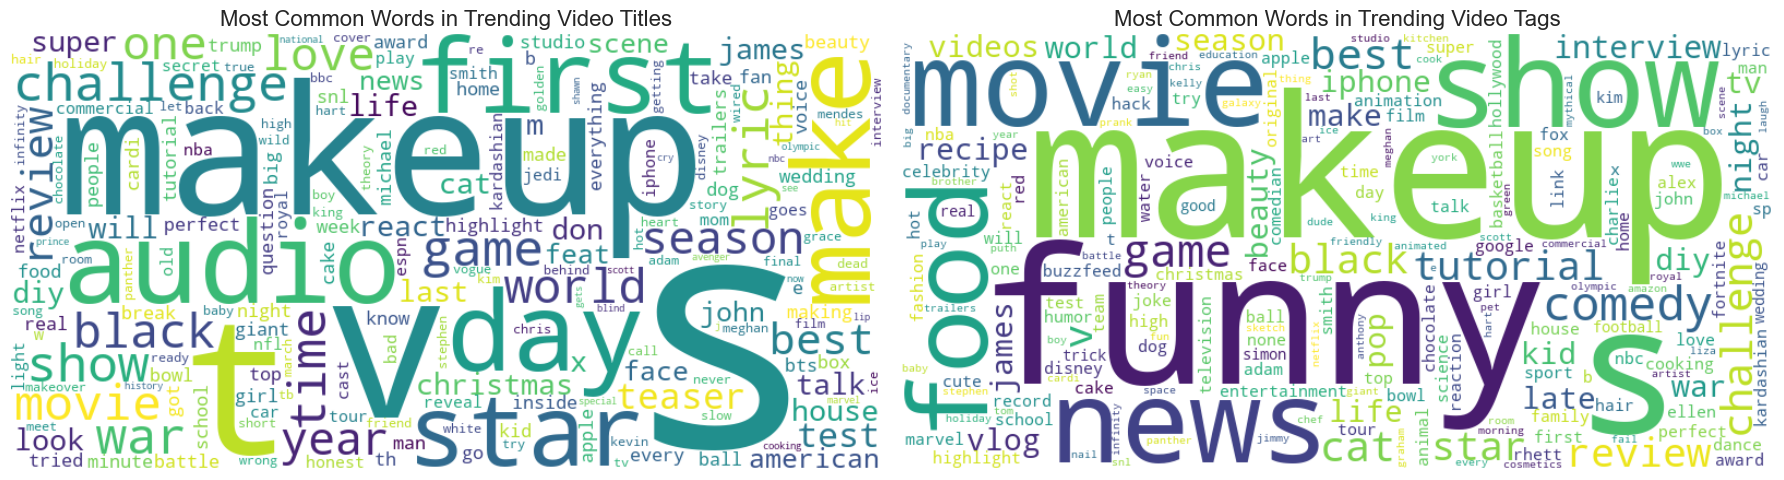


Top 20 Words in Trending Video Titles (Excluding Stopwords):
[('makeup', 876), ('audio', 872), ('first', 751), ('day', 698), ('challenge', 670), ('game', 604), ('black', 593), ('star', 572), ('world', 571), ('make', 569), ('lyric', 569), ('show', 566), ('time', 562), ('love', 535), ('movie', 509), ('season', 482), ('best', 468), ('teaser', 462), ('christmas', 443), ('one', 442)]

Top 20 Words in Trending Video Tags (Excluding Stopwords):
[('makeup', 7958), ('funny', 7323), ('show', 6025), ('news', 5888), ('food', 4826), ('comedy', 4768), ('movie', 4415), ('best', 4073), ('challenge', 3509), ('black', 3301), ('tutorial', 3009), ('game', 2917), ('review', 2910), ('life', 2872), ('star', 2852), ('world', 2778), ('interview', 2714), ('late', 2707), ('make', 2621), ('iphone', 2595)]


In [66]:
#Title/Tag Analysis (Word Clouds)

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

print("\n--- Title/Tag Analysis (Word Clouds) ---")

all_titles = ' '.join(df['title'].dropna().tolist()).lower()
all_tags = ' '.join([tag for sublist in df['tags'].dropna().tolist() for tag in sublist if tag and isinstance(tag, str)])

print(f"Length of all_titles string: {len(all_titles)}")
print(f"Length of all_tags string: {len(all_tags)}")
if not all_tags:
    print("WARNING: 'all_tags' string is empty BEFORE cleaning. This indicates an issue with the df['tags'] column or its prior processing.")
    print("Sample df['tags'] values (first 10, if any):")
    print(df['tags'].head(10).tolist())

custom_stopwords = STOPWORDS.union({
    'video', 'new', 'official', 'hd', 'hq', 'trailer', 'channel', 'watch',
    'live', 'ft', 'music', 'songs', 'clip', 'full', 'episode', 'series', 'part',
    'com', 'youtube', 'youtu', 'be', 'https', 'www', 'us', 'uk', 'de', 'fr', 'ca', 'mx', 'ru', 'jp', 'kr', 'in' # Added country codes
})

def clean_text_for_wordcloud(text):
    text = re.sub(r'[^\w\s]', ' ', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with single space and strip
    return text

#cleaning titles and tags
all_titles_cleaned = clean_text_for_wordcloud(all_titles)
all_tags_cleaned = clean_text_for_wordcloud(all_tags)

print(f"Length of all_titles_cleaned string: {len(all_titles_cleaned)}")
print(f"Length of all_tags_cleaned string: {len(all_tags_cleaned)}")
if not all_tags_cleaned:
    print("ERROR: 'all_tags_cleaned' ")
    print("This means all tags were either removed by cleaning, or were stopwords.")
    print("Consider reviewing your custom_stopwords or the content of your tags.")
    if not all_titles_cleaned:
        print("ERROR: 'all_titles_cleaned' is also empty. No word clouds can be generated.")
        
        exit() 

plt.figure(figsize=(18, 9))

if all_titles_cleaned: 
    wordcloud_titles = WordCloud(width=800, height=400, background_color='white',
                                 stopwords=custom_stopwords, collocations=False).generate(all_titles_cleaned)
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.imshow(wordcloud_titles, interpolation='bilinear')
    plt.title('Most Common Words in Trending Video Titles', fontsize=16)
    plt.axis('off') # Hide axes for cleaner display
else:
    plt.subplot(1, 2, 1)
    plt.text(0.5, 0.5, "No meaningful title words to display.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Most Common Words in Trending Video Titles (No Data)', fontsize=16)
    plt.axis('off')


if all_tags_cleaned:
    wordcloud_tags = WordCloud(width=800, height=400, background_color='white',
                               stopwords=custom_stopwords, collocations=False).generate(all_tags_cleaned)
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.imshow(wordcloud_tags, interpolation='bilinear')
    plt.title('Most Common Words in Trending Video Tags', fontsize=16)
    plt.axis('off') 
else:
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, "No meaningful tag words to display.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Most Common Words in Trending Video Tags (No Data)', fontsize=16)
    plt.axis('off')


plt.tight_layout() 
plt.show() # Displaying the plots

# Filtering words to be longer than 2 characters to exclude very short common words
title_words_list = [word for word in all_titles_cleaned.split() if word not in custom_stopwords and len(word) > 2]
tag_words_list = [word for word in all_tags_cleaned.split() if word not in custom_stopwords and len(word) > 2]


if title_words_list:
    print("\nTop 20 Words in Trending Video Titles (Excluding Stopwords):")
    print(Counter(title_words_list).most_common(20))
else:
    print("\nNo common words found in titles after filtering.")

if tag_words_list:
    print("\nTop 20 Words in Trending Video Tags (Excluding Stopwords):")
    print(Counter(tag_words_list).most_common(20))
else:
    print("\nNo common words found in tags after filtering.")



---Growth Patterns ---

Analyzing growth patterns for 8 videos that trended for > 7 days.


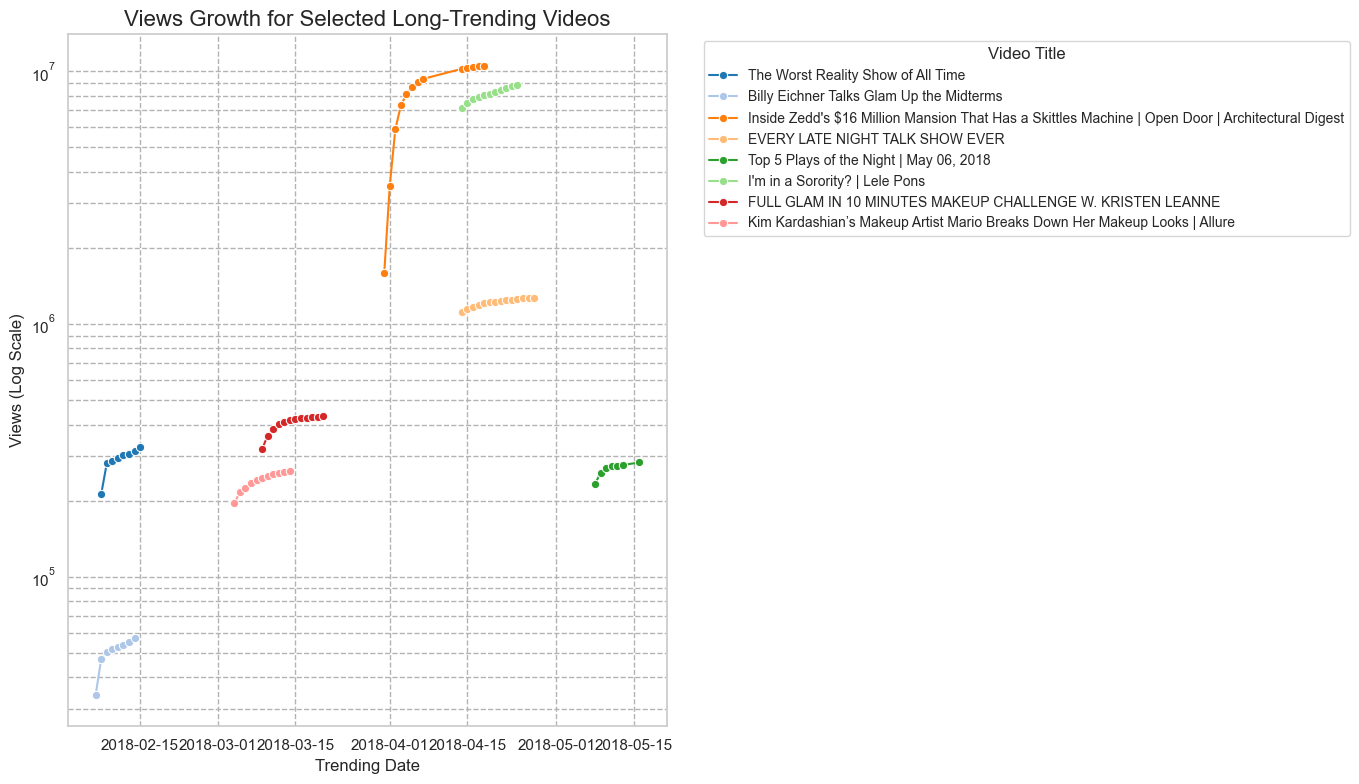

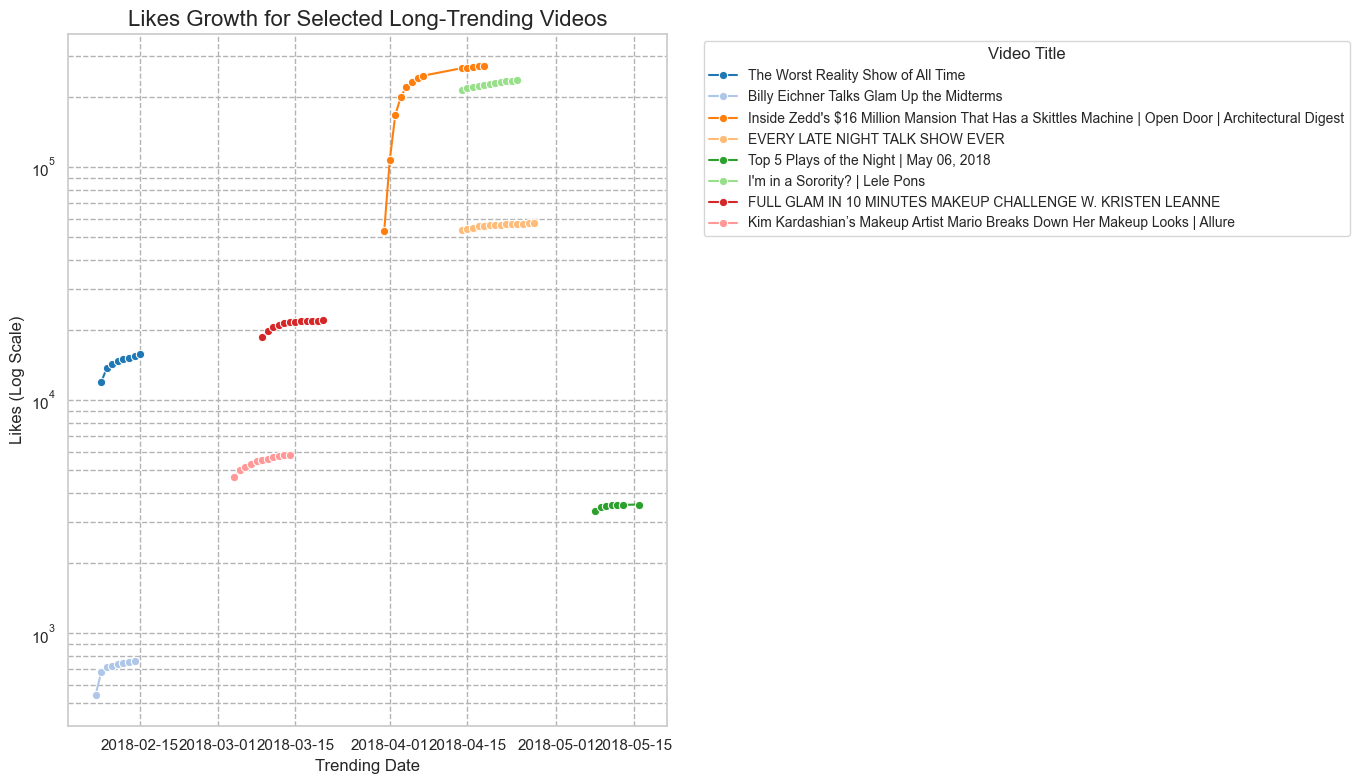


---Complete ---


In [67]:
#Growth Patterns
print("\n---Growth Patterns ---")

long_trending_video_ids = video_trending_summary[video_trending_summary['trending_duration_days'] > 7]['video_id'].sample(min(8, len(video_trending_summary[video_trending_summary['trending_duration_days'] > 7])), random_state=42).tolist()

if not long_trending_video_ids:
    print("\nNot enough long-trending videos (duration > 7 days) in your sample to show meaningful growth patterns.")
    print("Consider adjusting the 'trending_duration_days > 7' filter or increasing the sample size if your dataset allows.")
else:
    print(f"\nAnalyzing growth patterns for {len(long_trending_video_ids)} videos that trended for > 7 days.")
    growth_df = df[df['video_id'].isin(long_trending_video_ids)].copy()
    growth_df = growth_df.sort_values(by=['video_id', 'trending_date'])

    
    video_id_to_title = df.set_index('video_id')['title'].drop_duplicates().to_dict()
    growth_df['video_title'] = growth_df['video_id'].map(video_id_to_title)

    # Plot Views Growth
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=growth_df, x='trending_date', y='views', hue='video_title', marker='o', palette='tab20', legend='full')
    plt.title('Views Growth for Selected Long-Trending Videos', fontsize=16)
    plt.xlabel('Trending Date', fontsize=12)
    plt.ylabel('Views (Log Scale)', fontsize=12)
    plt.yscale('log') 
    plt.grid(True, which="both", ls="--", c=".7")
    plt.legend(title='Video Title', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot Likes Growth
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=growth_df, x='trending_date', y='likes', hue='video_title', marker='o', palette='tab20', legend='full')
    plt.title('Likes Growth for Selected Long-Trending Videos', fontsize=16)
    plt.xlabel('Trending Date', fontsize=12)
    plt.ylabel('Likes (Log Scale)', fontsize=12)
    plt.yscale('log') 
    plt.grid(True, which="both", ls="--", c=".7")
    plt.legend(title='Video Title', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.tight_layout()
    plt.show()

    # Interactive Plots with Plotly Express
    fig_views = px.line(growth_df, x='trending_date', y='views', color='video_title',
                        line_group='video_title', hover_name='video_title',
                        title='Interactive Views Growth for Selected Long-Trending Videos',
                        log_y=True)
    fig_views.update_traces(mode='markers+lines')
    fig_views.show()

    fig_likes = px.line(growth_df, x='trending_date', y='likes', color='video_title',
                        line_group='video_title', hover_name='video_title',
                        title='Interactive Likes Growth for Selected Long-Trending Videos',
                        log_y=True)
    fig_likes.update_traces(mode='markers+lines')
    fig_likes.show()

print("\n---Complete ---")







---Correlation Matrix ---


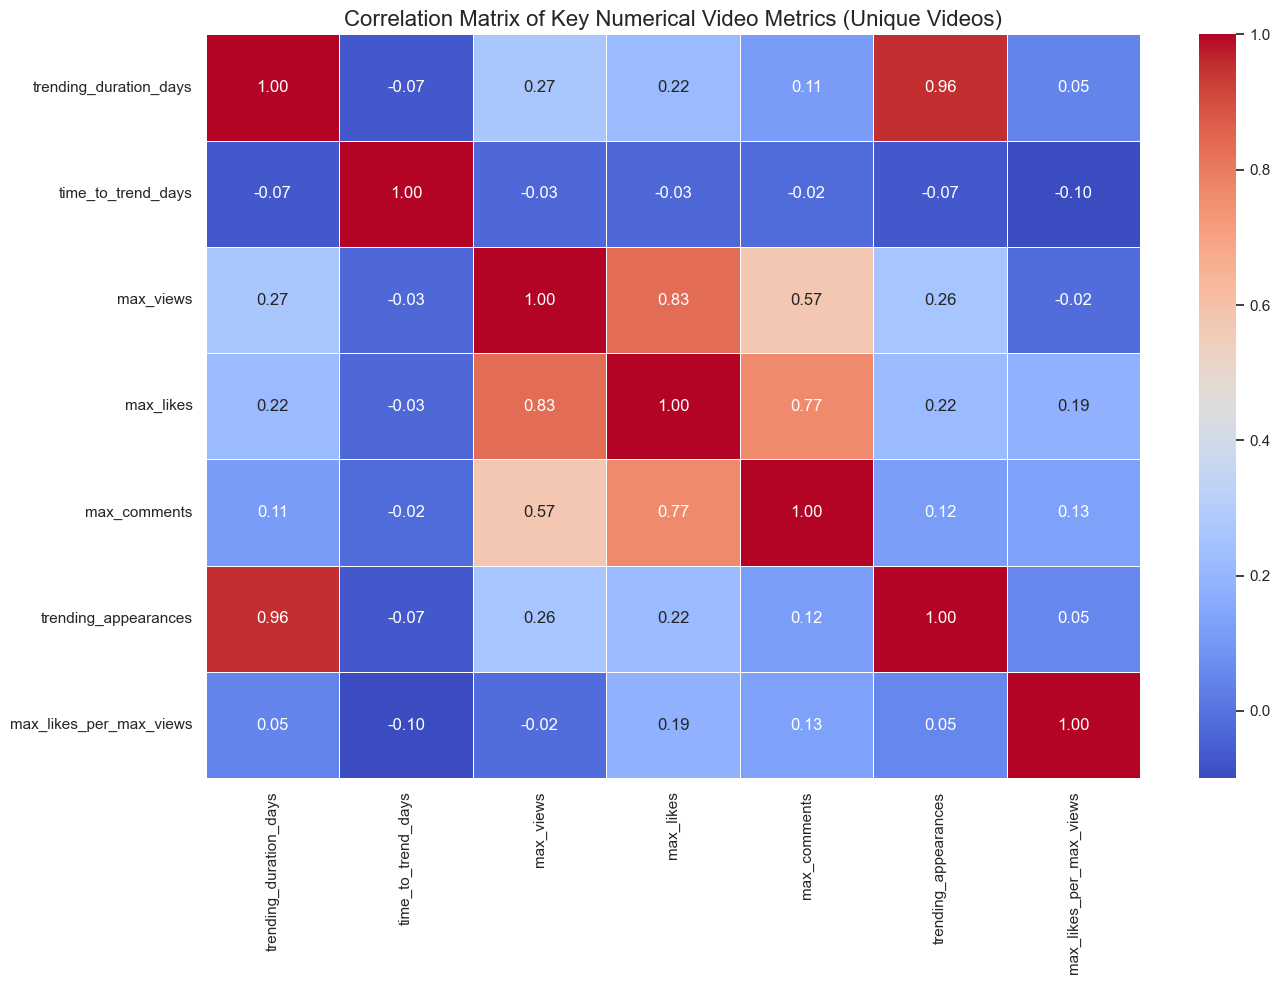

In [68]:

#Correlation Matrix
print("\n---Correlation Matrix ---")

correlation_features = video_trending_summary[['trending_duration_days', 'time_to_trend_days',
                                               'max_views', 'max_likes', 'max_comments',
                                               'trending_appearances']].copy()

correlation_features['max_likes_per_max_views'] = np.where(correlation_features['max_views'] > 0,
                                                           correlation_features['max_likes'] / correlation_features['max_views'], 0)

# Generating a heatmap of correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Numerical Video Metrics (Unique Videos)', fontsize=16)
plt.tight_layout()
plt.show()



---Outlier Detection (High Engagement, Low Views) ---

Videos with significantly high comments per view (>= 0.0091) 
but relatively low views (< 303431):
                                                   title  \
29559                            What is the BEST Fruit?   
19406            President Trump on bump stocks (C-SPAN)   
1839                 Top 10 Black Friday 2017 Tech Deals   
12830  Remy Ma - Melanin Magic (Pretty Brown) (Audio)...   
1640         How to do a beauty Vlog for Tarte Cosmetics   
13409                  Thousands rally for Women's March   
1878         How to do a beauty Vlog for Tarte Cosmetics   
2075         How to do a beauty Vlog for Tarte Cosmetics   
5234                                 Magical TEXAS SNOW!   
4843   It's Ok To Feel Sad At Christmas // Vlogmas Day 7   

                 channel_title         category_name   views  likes  \
29559               GingerPale                Comedy  179243  17090   
19406                   C-SPAN       News 

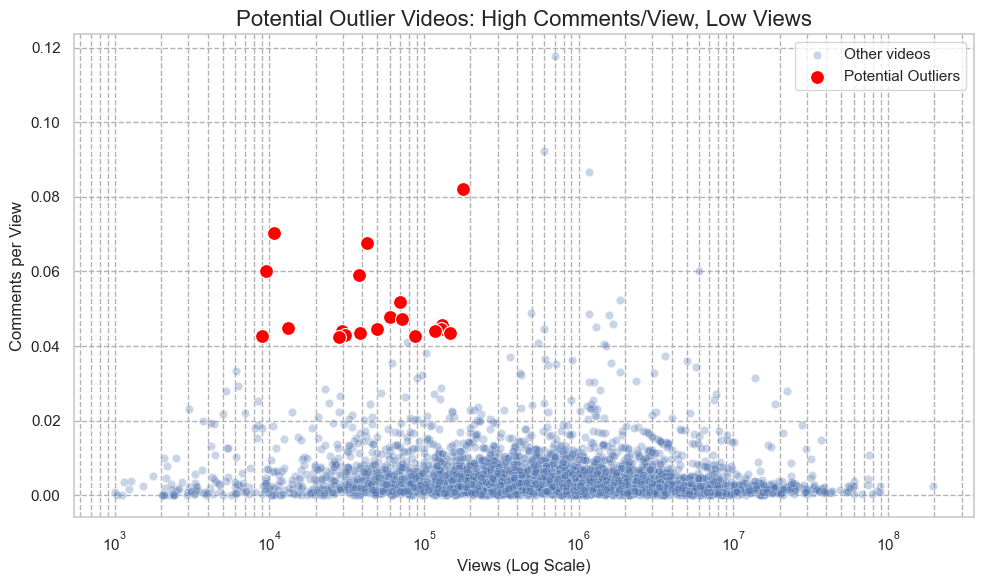

In [69]:

#Outlier Detection (High Engagement, Low Views)
print("\n---Outlier Detection (High Engagement, Low Views) ---")


view_threshold = df['views'].quantile(0.30) # Videos below 30th percentile in views
engagement_ratio_threshold = df['comments_per_view'].quantile(0.90) # Videos above 90th percentile in comments/view

potential_outliers = df[(df['views'] < view_threshold) & (df['comments_per_view'] >= engagement_ratio_threshold)].copy()
potential_outliers = potential_outliers.sort_values(by='comments_per_view', ascending=False)

print(f"\nVideos with significantly high comments per view (>= {engagement_ratio_threshold:.4f}) ")
print(f"but relatively low views (< {view_threshold:.0f}):")

if not potential_outliers.empty:
    # Displaying top 10 potential outliers, showing key features
    print(potential_outliers[['title', 'channel_title', 'category_name', 'views', 'likes', 'comment_count', 'comments_per_view']].head(10))

    #Plotting these outliers
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='views', y='comments_per_view', data=df.sample(n=min(5000, len(df)), random_state=42), alpha=0.3, label='Other videos')
    sns.scatterplot(x='views', y='comments_per_view', data=potential_outliers.head(20), color='red', s=100, label='Potential Outliers')
    plt.xscale('log')
    plt.title('Potential Outlier Videos: High Comments/View, Low Views', fontsize=16)
    plt.xlabel('Views (Log Scale)', fontsize=12)
    plt.ylabel('Comments per View', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", c=".7")
    plt.tight_layout()
    plt.show()

else:
    print("No significant outliers found based on current criteria.")







--- Time Series Trends & Seasonality ---


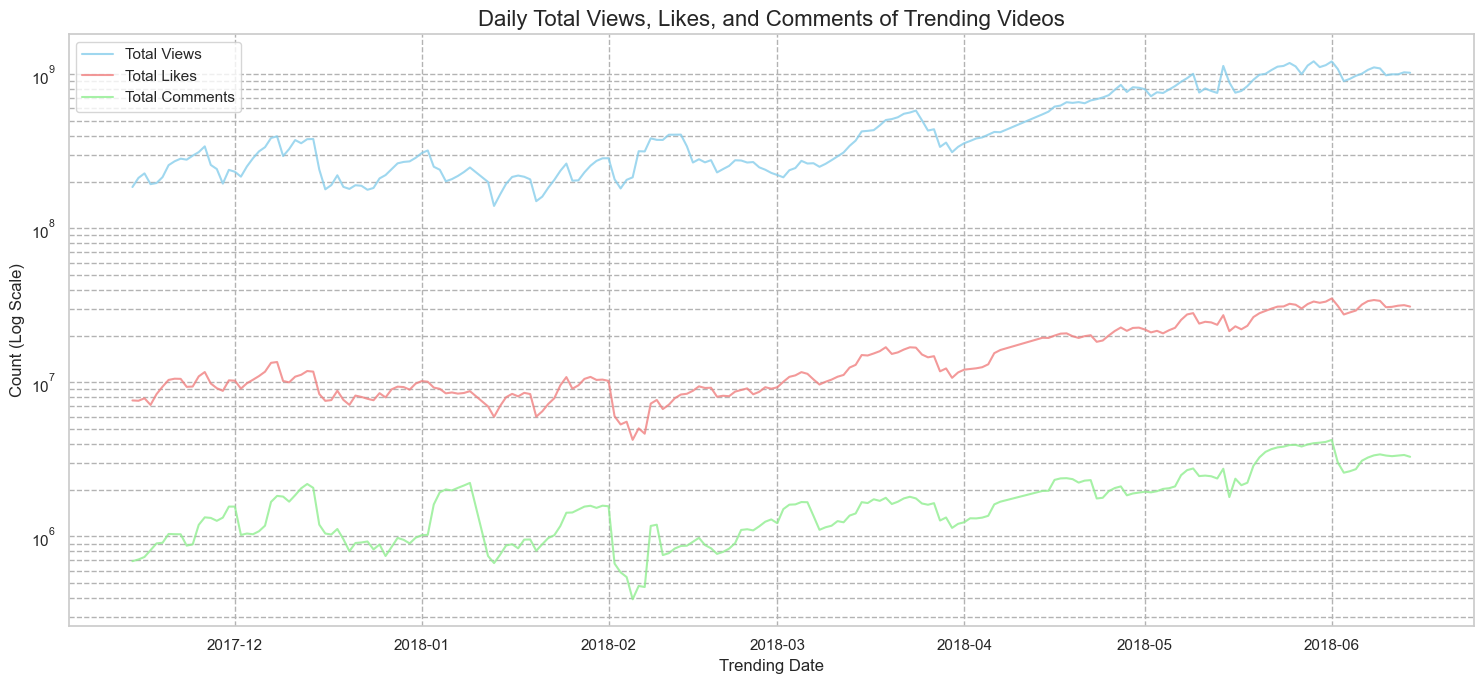

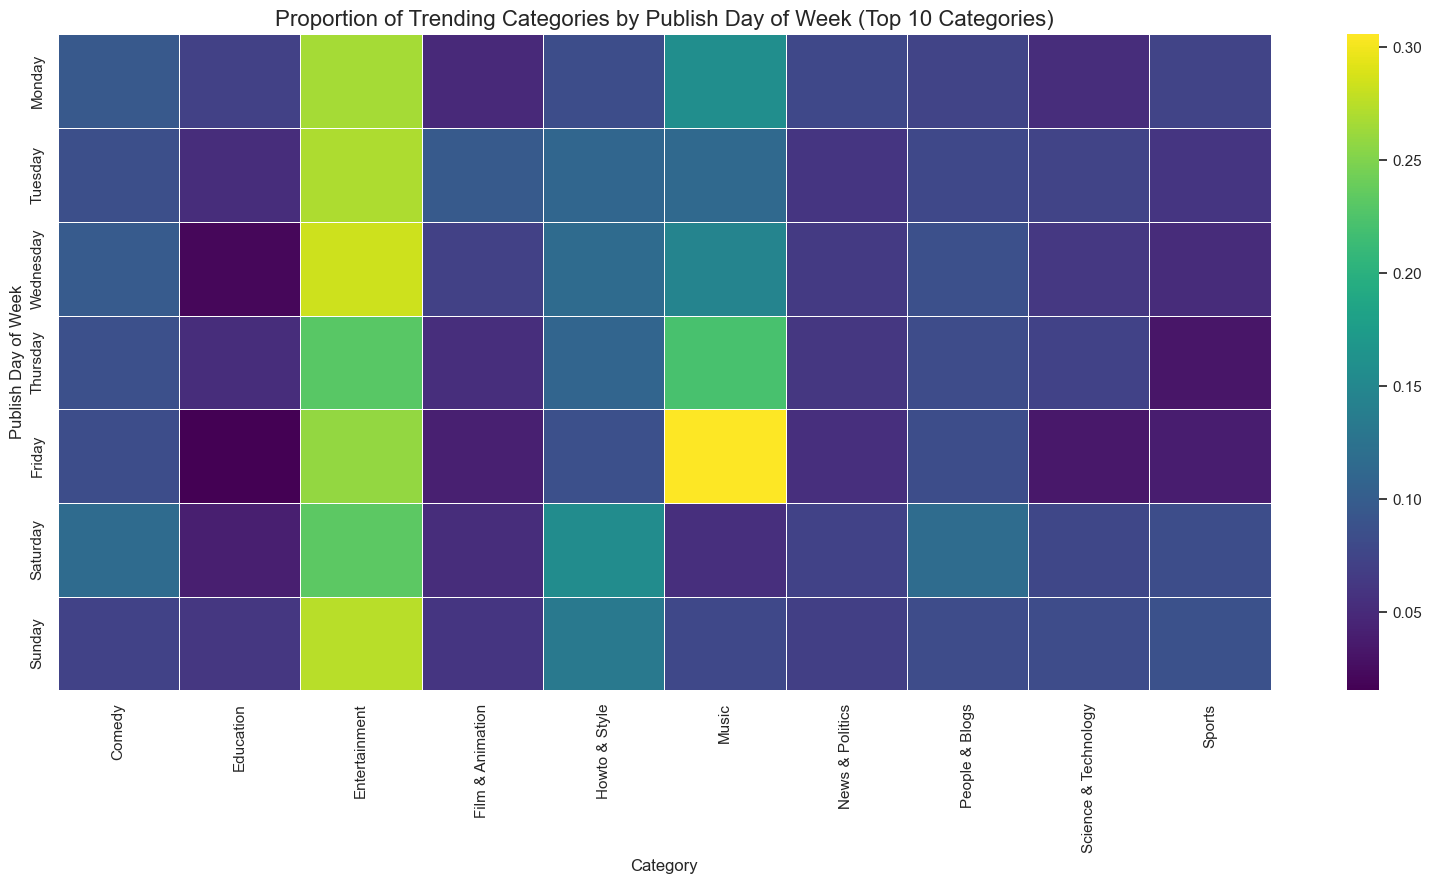

C:\Users\butte\AppData\Local\Temp\ipykernel_14020\2017946226.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




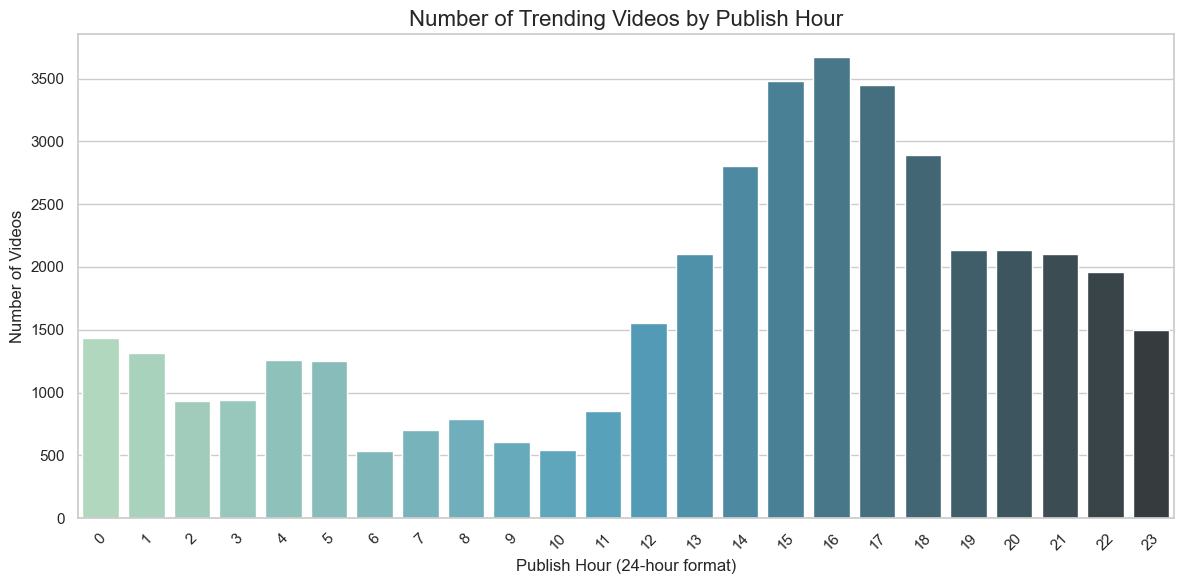

In [70]:
#Time Series Trends & Seasonality
print("\n--- Time Series Trends & Seasonality ---")

# Aggregating daily total views, likes, and comments for all trending videos
daily_metrics = df.groupby('trending_date')[['views', 'likes', 'comment_count']].sum().reset_index()

# Plotting daily trends
plt.figure(figsize=(15, 7))
plt.plot(daily_metrics['trending_date'], daily_metrics['views'], label='Total Views', color='skyblue', alpha=0.8)
plt.plot(daily_metrics['trending_date'], daily_metrics['likes'], label='Total Likes', color='lightcoral', alpha=0.8)
plt.plot(daily_metrics['trending_date'], daily_metrics['comment_count'], label='Total Comments', color='lightgreen', alpha=0.8)
plt.title('Daily Total Views, Likes, and Comments of Trending Videos', fontsize=16)
plt.xlabel('Trending Date', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.yscale('log') # Use log scale for better visualization of wide ranges
plt.legend()
plt.grid(True, which="both", ls="--", c=".7")
plt.tight_layout()
plt.show()

# Seasonality: Analyzing trending patterns by publish day of week
# Calculating the count of trending entries per category per publish day of week
daily_avg_category = df.groupby(['publish_day_of_week', 'category_name']).size().unstack(fill_value=0)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Filter to top 10 categories
top_10_categories = df['category_name'].value_counts().head(10).index.tolist()
daily_avg_category = daily_avg_category.reindex(day_order).loc[:, daily_avg_category.columns.isin(top_10_categories)]


plt.figure(figsize=(16, 9))
# Plotting proportions (normalized per day)
sns.heatmap(daily_avg_category.div(daily_avg_category.sum(axis=1), axis=0), cmap='viridis', annot=False, fmt=".2f", linewidths=.5)
plt.title('Proportion of Trending Categories by Publish Day of Week (Top 10 Categories)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Publish Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

# Analyzing trending patterns by publish hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=df, palette='GnBu_d', order=sorted(df['publish_hour'].unique()))
plt.title('Number of Trending Videos by Publish Hour', fontsize=16)
plt.xlabel('Publish Hour (24-hour format)', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



--- Channel Deep Dive ---

Top 15 Channels by Trending Appearances (count of trending entries):
channel_title
ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
TheEllenShow                              193
Vox                                       193
Netflix                                   193
The Late Show with Stephen Colbert        187
Jimmy Kimmel Live                         186
Late Night with Seth Meyers               183
Screen Junkies                            182
NBA                                       181
CNN                                       180
Saturday Night Live                       175
WIRED                                     171
BuzzFeedVideo                             169
INSIDER                                   167
Name: count, dtype: int64

Average Engagement Metrics for Top Trending Channels:
                             channel_title     avg_views     avg_likes  \
0                                     ESPN  

C:\Users\butte\AppData\Local\Temp\ipykernel_14020\4089962547.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




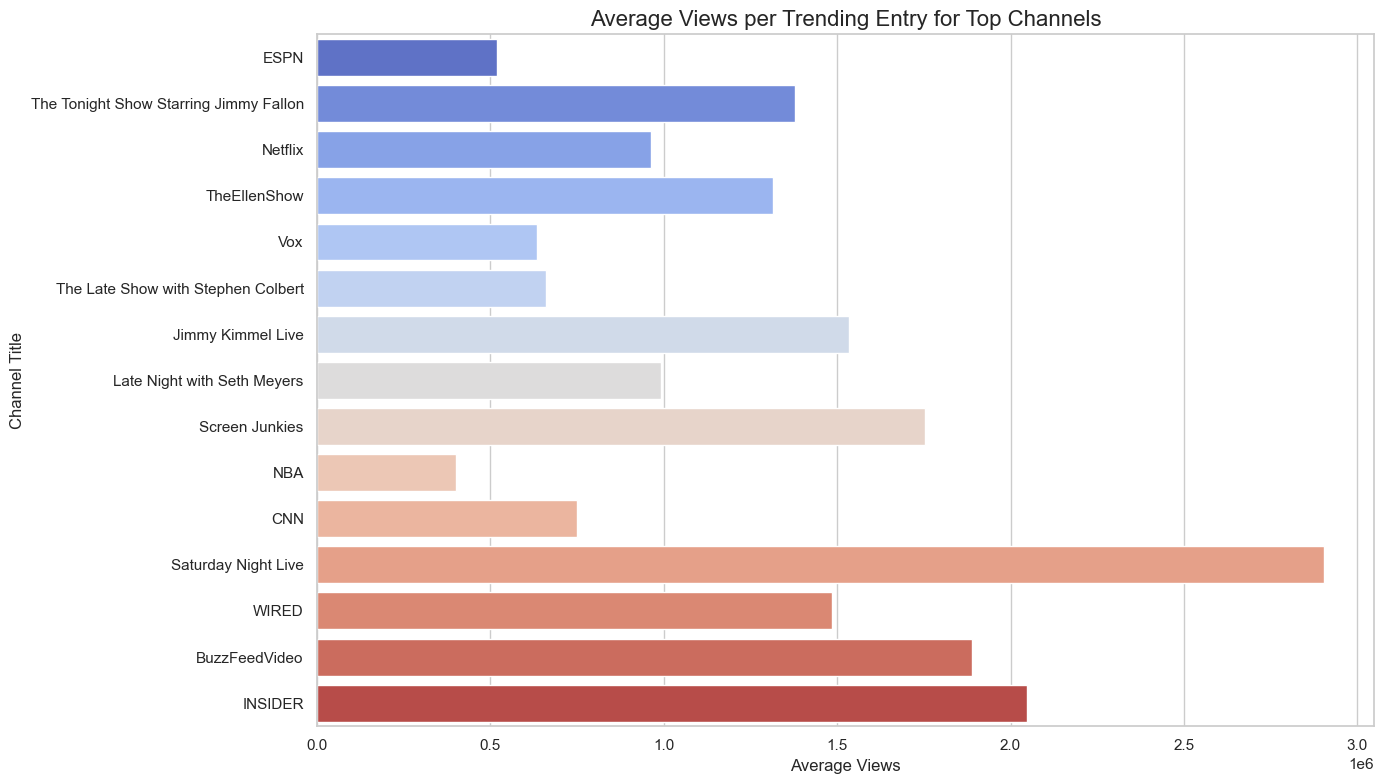


Category Breakdown for Top Trending Channels:
category_name                           Autos & Vehicles  Comedy  \
channel_title                                                      
ESPN                                                   0       0   
The Tonight Show Starring Jimmy Fallon                 0     197   
Netflix                                                0       0   
TheEllenShow                                           0       0   
Vox                                                    0       0   

category_name                           Entertainment  Film & Animation  \
channel_title                                                             
ESPN                                                0                 0   
The Tonight Show Starring Jimmy Fallon              0                 0   
Netflix                                           193                 0   
TheEllenShow                                      193                 0   
Vox                       

In [71]:
#Channel Deep Dive
print("\n--- Channel Deep Dive ---")

# Identifying top N channels by number of trending videos (entries)
top_channels = df['channel_title'].value_counts().head(15).index.tolist()
print(f"\nTop 15 Channels by Trending Appearances (count of trending entries):\n{df['channel_title'].value_counts().head(15)}")

# Analyzing average engagement metrics for these top channels
channel_engagement = df[df['channel_title'].isin(top_channels)].groupby('channel_title').agg(
    avg_views=('views', 'mean'),
    avg_likes=('likes', 'mean'),
    avg_comments=('comment_count', 'mean'),
    total_trending_entries=('video_id', 'count') # Count of trending entries for this channel
).sort_values(by='total_trending_entries', ascending=False).reset_index()

print("\nAverage Engagement Metrics for Top Trending Channels:")
print(channel_engagement)

# Plotting average views per trending entry for top channels
plt.figure(figsize=(14, 8))
sns.barplot(x='avg_views', y='channel_title', data=channel_engagement, palette='coolwarm')
plt.title('Average Views per Trending Entry for Top Channels', fontsize=16)
plt.xlabel('Average Views', fontsize=12)
plt.ylabel('Channel Title', fontsize=12)
plt.tight_layout()
plt.show()

# Analyzing category focus for top channels
top_channel_category_breakdown = df[df['channel_title'].isin(top_channels)].groupby(['channel_title', 'category_name']).size().unstack(fill_value=0)
top_channel_category_breakdown['Total Trending Entries'] = top_channel_category_breakdown.sum(axis=1) # Sum of trending entries for each channel
top_channel_category_breakdown = top_channel_category_breakdown.sort_values(by='Total Trending Entries', ascending=False)

print("\nCategory Breakdown for Top Trending Channels:")
# Display top 5 channels
print(top_channel_category_breakdown.head(5))



Engagement Threshold (top 25% starts at): 42793 positive engagements
Distribution of target variable ('is_high_engagement'):
is_high_engagement
0    4763
1    1588
Name: count, dtype: int64

Training data shape: (5080, 2)
Testing data shape: (1271, 2)

--- Training Machine Learning Model ---
Model training complete.

--- Evaluating Machine Learning Model ---

Accuracy Score:
0.7821

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       953
           1       0.64      0.30      0.40       318

    accuracy                           0.78      1271
   macro avg       0.72      0.62      0.64      1271
weighted avg       0.76      0.78      0.75      1271


Confusion Matrix:
[[900  53]
 [224  94]]


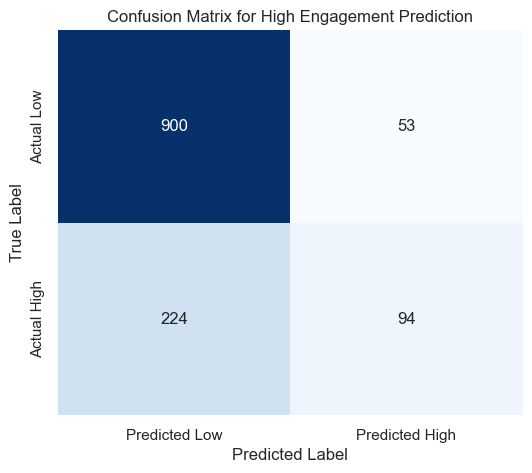

In [72]:
#Using Machine Learning: Predicting High Engagement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


if 'video_trending_summary' not in locals():
    print("Error: 'video_trending_summary' DataFrame not found or not fully processed.")
    raise RuntimeError("video_trending_summary is not available.")



video_trending_summary['max_positive_engagement'] = video_trending_summary['max_likes'] + video_trending_summary['max_comments']


engagement_threshold = video_trending_summary['max_positive_engagement'].quantile(0.75)
video_trending_summary['is_high_engagement'] = (video_trending_summary['max_positive_engagement'] >= engagement_threshold).astype(int)

print(f"\nEngagement Threshold (top 25% starts at): {engagement_threshold:.0f} positive engagements")
print(f"Distribution of target variable ('is_high_engagement'):\n{video_trending_summary['is_high_engagement'].value_counts()}")


features = ['category_name', 'trending_appearances']
target = 'is_high_engagement'

X = video_trending_summary[features]
y = video_trending_summary[target]


numerical_features = ['trending_appearances']
categorical_features = ['category_name']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(random_state=42))])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Model Training
print("\n--- Training Machine Learning Model ---")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

# Model Evaluation
print("\n--- Evaluating Machine Learning Model ---")
y_pred = model_pipeline.predict(X_test)

print("\nAccuracy Score:")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for High Engagement Prediction')
plt.show()